### 2022 날씨 빅데이터 콘테스트 Smart_Farm 모델

### 목표


스마트 팜에서 효율적이고 생산적인 에너지 절감 모델 제시  
모델에 활용된 분석기법 및 방법  

### 진행 단계

#### 1. 데이터 셋 확인 및 전처리
    - 데이터 import 및 확인
    - 결측치 처리
    - 데이터 이상치(Noise) 제거
    
#### 2. 데이터분석과 모델별 학습 데이터 생성
    - 탐색적 데이터 분석(EDA, Exploratory Data Analysis)
    - 확증적 데이터 분석(CDA, Confirmatory Data Analysis)
    - 복합제어 시스템 모델, 절감 모델 데이터 생성  
    
#### 3. 특성공학(Feature Engineering)
    - Data Normalization
    
#### 4. 모델 구축 및 학습
    - Cross Validation(10-fold)
    - Models: lightgbm, xgboost, svr, ridge, random forest, gradient boosting
    - Blending: 좋은 성능의 prediction을 위해 학습된 모델들을 결합해 사용  
    
#### 5. 모델 비교 및 평가
    - 모델별 정확도(rmse) 확인
    - 기존 모델(복합 환경제어 시스템)과 절감 모델(기상, 기후 데이터 고려) 일별 열공급량 비교
    

### 데이터 셋 확인 및 전처리

smart_farm 데이터를 불러오고 확인해보겠습니다.  



In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sklearn
from copy import deepcopy

plt.style.use('seaborn') # plt에 seaborn cheme 지정
sns.set(font_scale=2.5) # 그래프 font size 지정

import missingno as msno

import warnings
warnings.filterwarnings('ignore') #워닝 메세지 생략

%matplotlib inline

# 지표온도 isitu-LST --> Surface-TA
farm_df = pd.read_csv('./smart_farm_data.csv')
farm_df.columns = ["index","yy","mm","dd","hh","nn","insolation","out_tmperature",
                    "out_humidity",'wind_speed','wind_direction','in_tmperature','in_humidity',"shield_light_h","shield_tmperature_h",
                    "shield_energy_h","shield_energy_v","exhaust_fan","ceiling","floating_fan","fan_coil_b_site","ventilation_temperature_control",
                    "heating_temperature_set_up","heat_supply"]

In [5]:
farm_df

,index,yy,mm,dd,hh,nn,insolation,out_tmperature,out_humidity,wind_speed,...,shield_tmperature_h,shield_energy_h,shield_energy_v,exhaust_fan,ceiling,floating_fan,fan_coil_b_site,ventilation_temperature_control,heating_temperature_set_up,heat_supply
0,1,2021,11,26,0,0,-2.7,5.8,67,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
1,2,2021,11,26,0,1,-2.9,5.8,67,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
2,3,2021,11,26,0,2,-3.0,5.7,67,0.9,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.9
3,4,2021,11,26,0,3,-3.0,5.7,67,1.3,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
4,5,2021,11,26,0,4,-2.8,5.7,67,0.9,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152635,152636,2022,3,20,23,55,-3.0,6.2,61,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN
152636,152637,2022,3,20,23,56,-3.2,6.2,61,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN
152637,152638,2022,3,20,23,57,-3.2,6.1,61,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN
152638,152639,2022,3,20,23,58,-3.3,6.1,61,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN


#### Smart Farm 데이터 Null 값 제거(결측치 처리)

In [18]:
farm_df = farm_df.dropna(axis = 0)

In [10]:
farm_df2 = deepcopy(farm_df)
farm_df

,index,yy,mm,dd,hh,nn,insolation,out_tmperature,out_humidity,wind_speed,...,shield_tmperature_h,shield_energy_h,shield_energy_v,exhaust_fan,ceiling,floating_fan,fan_coil_b_site,ventilation_temperature_control,heating_temperature_set_up,heat_supply
0,1,2021,11,26,0,0,-2.7,5.8,67,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
1,2,2021,11,26,0,1,-2.9,5.8,67,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
2,3,2021,11,26,0,2,-3.0,5.7,67,0.9,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.9
3,4,2021,11,26,0,3,-3.0,5.7,67,1.3,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
4,5,2021,11,26,0,4,-2.8,5.7,67,0.9,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132475,132476,2022,2,28,23,55,-2.7,4.1,51,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.9
132476,132477,2022,2,28,23,56,-2.7,4.1,52,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
132477,132478,2022,2,28,23,57,-2.7,4.1,52,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
132478,132479,2022,2,28,23,58,-2.6,4.1,52,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8


### 데이터 분석 (Data Analysis)

지금부터 데이터들을 분석하고 머신러닝에 사용될 중요한 변수들을 선택하고 검증해보겠습니다.
머신러닝, AI에서는 데이터와 얻고자하는 결과값간의 의미있는 관계가 중요합니다.  
중요한 관계들이 머신러닝 모델의 분류기준이 되고 이 기준들에 따라 모델의 성능과 성향이    
정해지기 때문입니다.  

##### 1) 탐색적 데이터 분석(EDA, Exploratory Data Analysis)
##### 2) 확증적 데이터 분석(CDA, Confirmatory Data Analysis)

여기서는 위 2가지의 데이터 분석 과정을 진행해보겠습니다.    
1) 탐색적 데이터 분석은 원 데이터(Raw Data)를 유연하게 탐색하고 데이터의 특징과 구조로부터  
얻은 정보를 바탕으로 통계모형을 탐색하는 방법입니다.

2) 확증적 데이터 분석은 가설을 설정한 후, 수집한 데이터로 가설을 평가하고 추정하는 다소 전통적인  
분석방법입니다. 데이터의 유의성 검정, 신뢰구간 추정등의 통계적 추론을 분석하는 방법입니다.  


### 탐색적 데이터 분석 (EDA)


### 각 제어 장치별 Heat supply(열 공급량) 확인


#### 팬 코일에 따른 열 공급량

Text(0.5, 1.0, 'heat_supply by fan_coil')

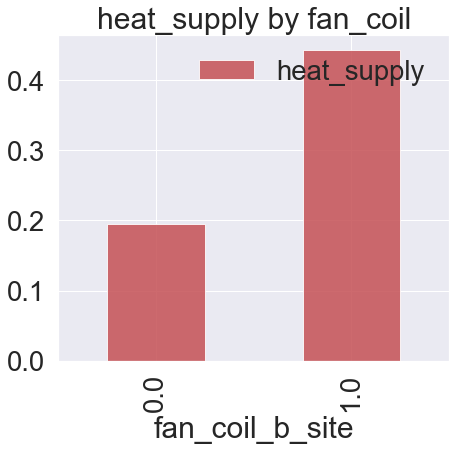

In [11]:
f, ax = plt.subplots(1, 1, figsize = (7,6))
farm_df[['fan_coil_b_site', 'heat_supply']].groupby(['fan_coil_b_site'], as_index = True).mean().plot.bar(ax = ax,color = ['r'], alpha = 0.84)
ax.set_title("heat_supply by fan_coil")

팬 코일에 따른 열 공급량 그래프입니다.  
열 공급량과 가장 연관이 높은 장치이고 난방 설정 온도보다 smart_farm 내부 온도가  
낮아질 경우 동작됩니다.  
위 그래프를 보면 팬 코일이 동작될 경우 열 공급량 수치가 늘어나는걸 확인할 수 있습니다.  

#### 배기팬에 따른 열 공급량

Text(0.5, 1.0, 'heat_supply by exhaust_fan')

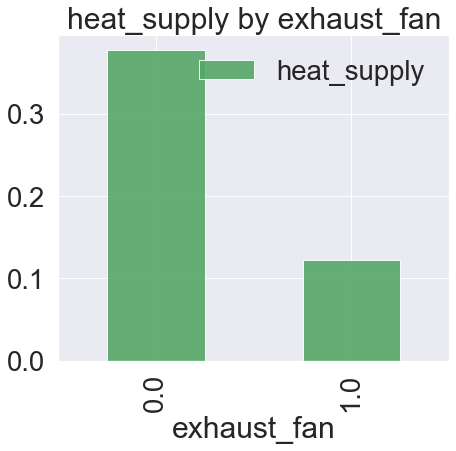

In [12]:
f, ax = plt.subplots(1, 1, figsize = (7,6))
farm_df[['exhaust_fan', 'heat_supply']].groupby(['exhaust_fan'], as_index = True).mean().plot.bar(ax = ax,
                                                                                                color = ['g'], alpha = 0.9)
ax.set_title("heat_supply by exhaust_fan")

배기팬은 팬코일과 반비례적인 그래프가 나타납니다.  
배기팬의 경우, smart_farm 실내 온도가 기준 천장 온도 이상으로 높아질 경우  
열을 환기하기 위해 동작됩니다. 고로, 팬 코일의 동작이 멈출경우(온도가 너무 높아진 경우)  
배기팬이 동작됩니다. 열 공급량이 낮아진걸 보면 배기팬보다는 팬코일 난방시스템이 열 공급량과  
더 밀접한것을 확인할 수 있습니다.

#### 천창 제어에 따른 열공급량

Text(0.5, 1.0, 'heat_supply by ceiling')

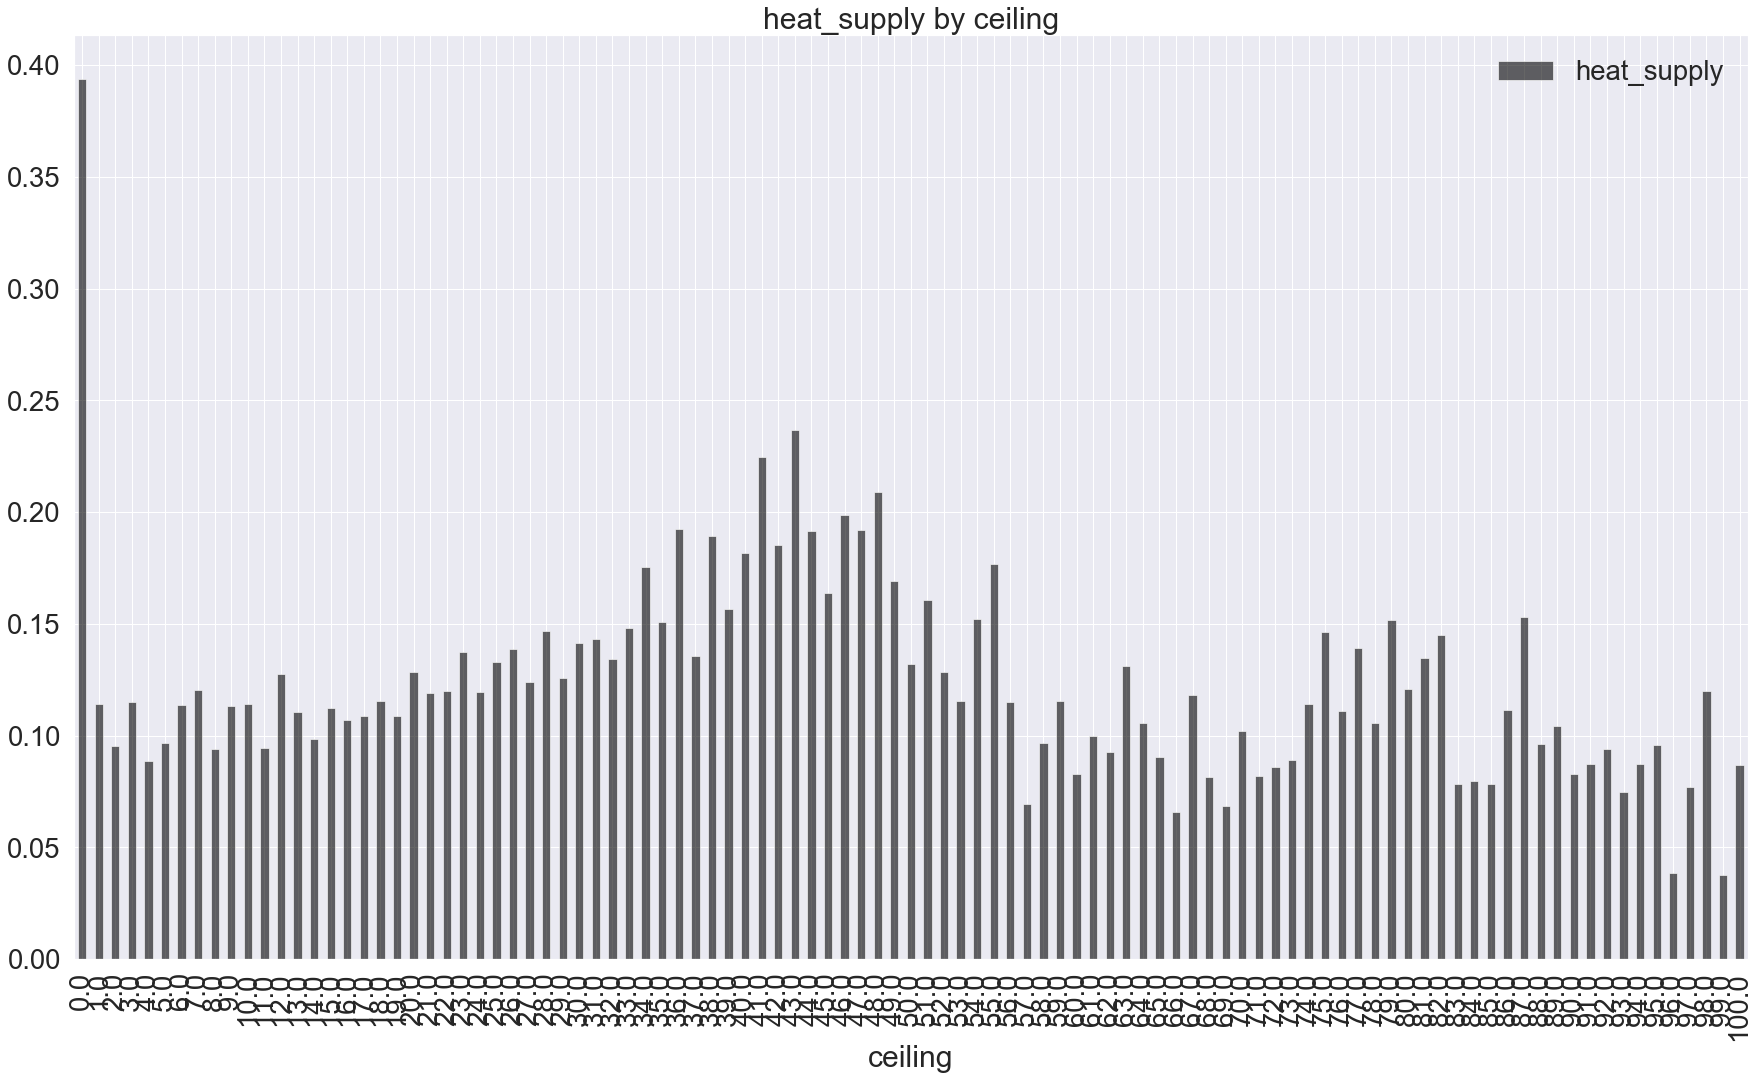

In [13]:
f, ax = plt.subplots(1, 1, figsize = (30,17))
farm_df[['ceiling', 'heat_supply']].groupby(['ceiling'], as_index = True).mean().plot.bar(ax = ax,
                                                                                                color = ['black'], alpha = 0.6)
ax.set_title("heat_supply by ceiling")

천창 제어에 따른 열 공급량입니다.  
천창은 온실 내부가 환기온도 이상으로 상승시 동작됩니다. 이는 배기판과 같은 원리이며  
역시 같은 흐름의 그래프를 보입니다.

지금까지 알아본 팬코일, 배기팬, 찬창데이터는 heat_supply와 밀접한 관계를 가집니다.  

### 기후에 따른 Heat supply(열 공급량) 확인

기후에 따라서 난방정도가 변하고, 그에 따라 열 공급량역시 변하게 됩니다.  
또한 여러번 대회 멘토링으로 문의해본 결과 기존의 복합제어시스템(스마트팜 제공 데이터)  
에서 기상청에서 제공하는 기상/기후 데이터를 활용해 절감모델을 만들고 이를 비교하는 것이  
중요하다고 하셨습니다.  
그에 따라, 기상/기후에 따른 열 공급량 부분을 중점적으로 보고 절감모델을 설계하는데에 활용하겠습니다.  

#### 시간에 따른 열 공급량

Text(0.5, 1.0, 'heat_supply by hour')

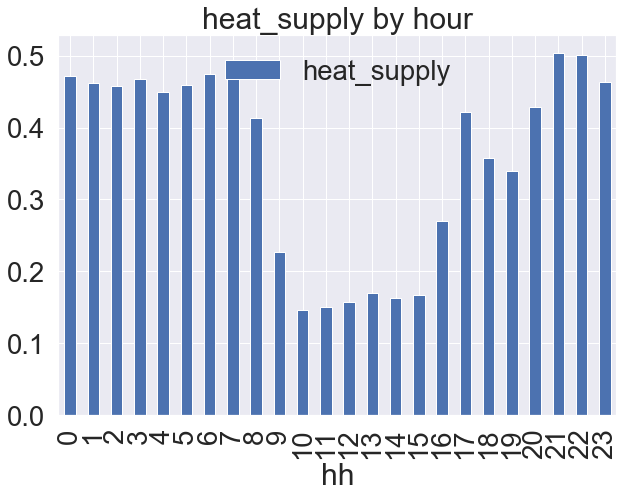

In [75]:
f, ax = plt.subplots(1, 1, figsize = (10,7) )
farm_df[['hh', 'heat_supply']].groupby(['hh'], as_index = True).mean().plot.bar(ax = ax)
ax.set_title("heat_supply by hour")

시간에 따른 열 공급량 그래프입니다. 기온이 낮아지는 오후~밤 시간대(17 ~ 8시)에  
열 공급량이 늘어나는 것을 확인할 수 있습니다.


Text(0.5, 1.0, 'out_tmperature by hour')

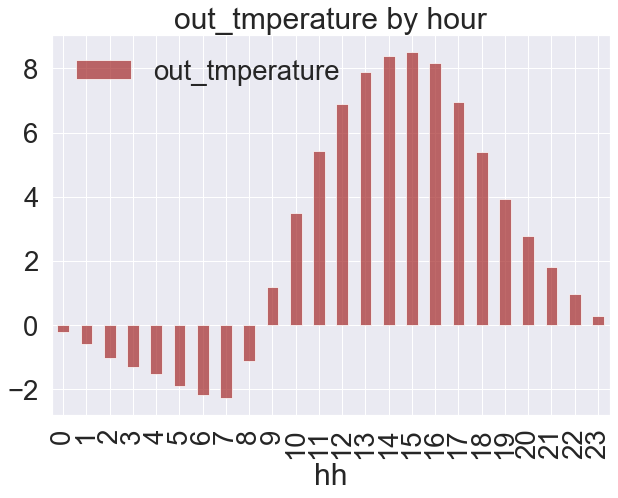

In [76]:
f, ax = plt.subplots(1, 1, figsize = (10,7))
farm_df[['hh', 'out_tmperature']].groupby(['hh'], as_index = True).mean().plot.bar(ax = ax, color = ['brown'], alpha = 0.7)
ax.set_title("out_tmperature by hour")

이번엔 시간에 따른 바깥온도 그래프입니다. 기온은 7시부터 상승해서 15시에 최고점을 찍고  
7시까지 하강하는 경향을 보입니다.  

#### 바깥 온도(Out TA)별 열 공급량

Text(0.5, 1.0, 'Heat_supply by Out-TA')

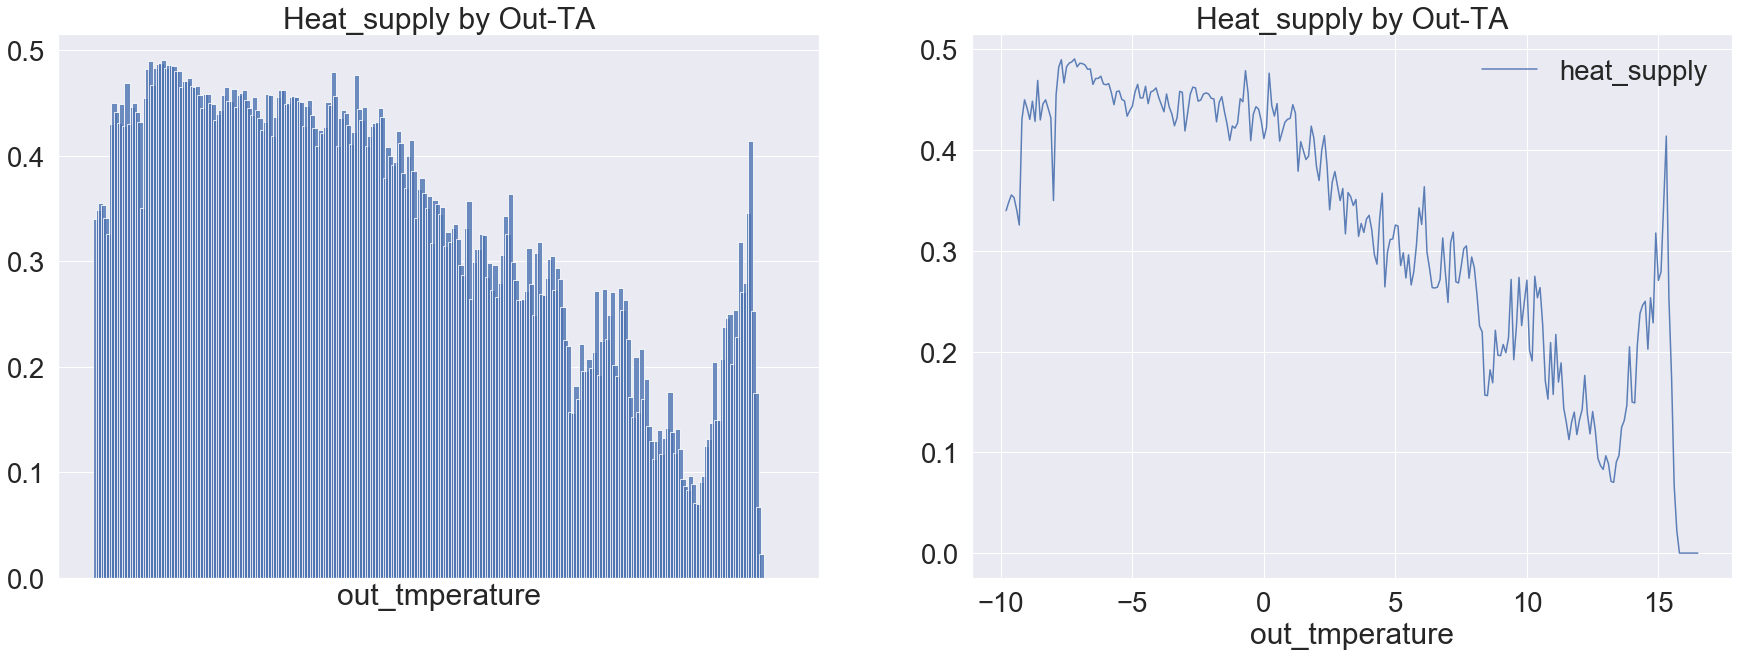

In [68]:
f, ax = plt.subplots(1, 2, figsize = (30,10))

x = farm_df[['out_tmperature', 'heat_supply']].groupby(['out_tmperature'], as_index = True).mean().index
y = farm_df[['out_tmperature', 'heat_supply']].groupby(['out_tmperature'], as_index = True).mean().values
y = np.array(y)
y = np.reshape(y,len(y))

ax[0].bar(x, y, color='b', label='Demand', alpha=0.8, width=0.2)
ax[0].axes.xaxis.set_ticks([])
ax[0].set_title("Heat_supply by Out-TA")
ax[0].set_xlabel("out_tmperature")

farm_df[['out_tmperature', 'heat_supply']].groupby(['out_tmperature'], as_index = True).mean().plot(ax = ax[1], color = ['b'], alpha = 0.9)
ax[1].set_title("Heat_supply by Out-TA")

바깥 온도에별 열 공급량 그래프입니다.  
기온이 높아질수록 열 공급량은 하강하는 경향을 보입니다. 그러다가 13~14즈음부터는 어느정도 열 공급량이  
상승하는 경향을 보입니다.


#### 바깥 습도(Out TA)별 열 공급량

Text(0.5, 1.0, 'Heat_supply by out_humidity')

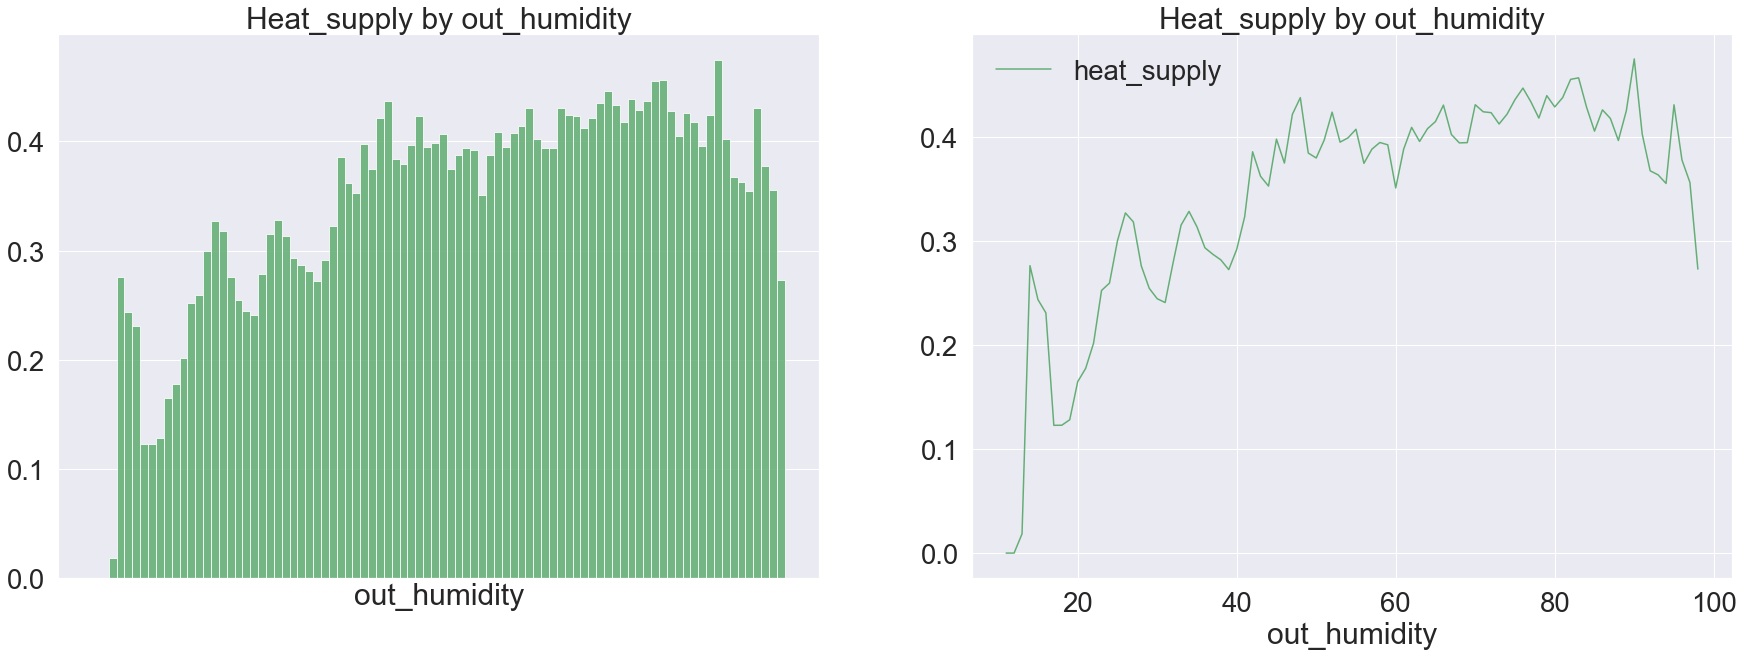

In [69]:
f, ax = plt.subplots(1, 2, figsize = (30,10))

x = farm_df[['out_humidity', 'heat_supply']].groupby(['out_humidity'], as_index = True).mean().index
y = farm_df[['out_humidity', 'heat_supply']].groupby(['out_humidity'], as_index = True).mean().values
y = np.array(y)
y = np.reshape(y,len(y))

ax[0].bar(x, y, color='g', label='Demand', alpha=0.8, width=1)
ax[0].axes.xaxis.set_ticks([])
ax[0].set_title("Heat_supply by out_humidity")
ax[0].set_xlabel("out_humidity")

farm_df[['out_humidity', 'heat_supply']].groupby(['out_humidity'], as_index = True).mean().plot(ax = ax[1], color = ['g'], alpha = 0.9)
ax[1].set_title("Heat_supply by out_humidity")

이번에는 습도별 열공급량입니다. 습도가 높아질수록 열 공급량은 상승하는 경향을 보입니다.  
이는 공기 속에 있는 수분이 냉기를 전달하는 역할을 하기 때문인것으로 보입니다.  
(참고: https://imnews.imbc.com/replay/2020/nwtoday/article/5973475_32531.html)

사람으로 기준을 삼으면 여름의 최적 습도는 60%, 봄, 가을은 50%, 겨울의 적정 습도는 40%라고 합니다.  
식물도 생명체이고 습도에 따라서 열을 전달받는 정도가 달라질 가능성이 높습니다.  

고로, 현재 적용되고 있는 스마트팜 제이시스템에 더불어 습도 조절기를 실내에 배치해둔다면  
난방효과내지 식물 생장에 효과를 좀 더 볼 수 있지 않을까 싶습니다.

#### 일 사량(insolation)별 열 공급량

Text(0.5, 1.0, 'out_tmperature by insolation')

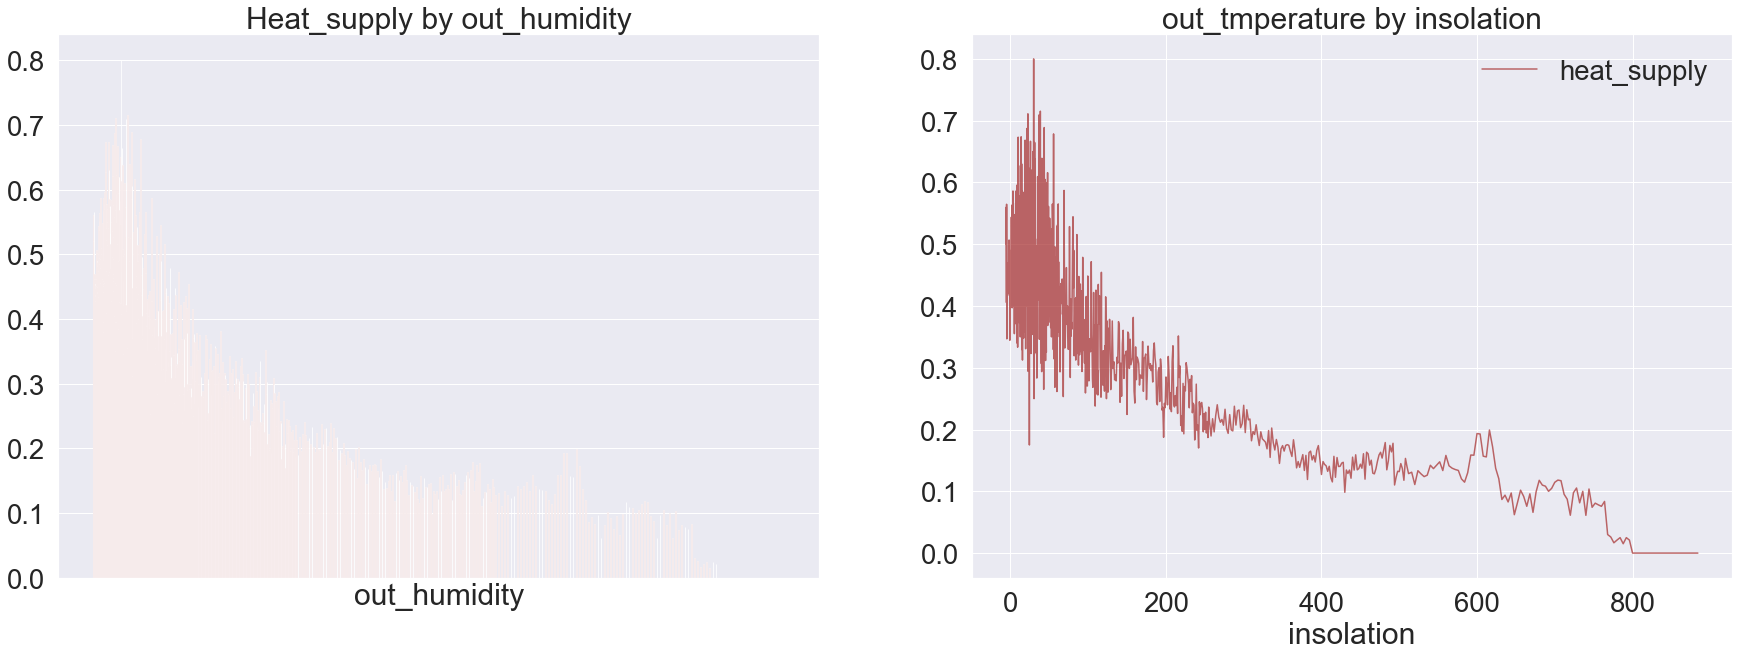

In [70]:
f, ax = plt.subplots(1, 2, figsize = (30,10))

x = farm_df[['insolation', 'heat_supply']].groupby(['insolation'], as_index = True).mean().index
y = farm_df[['insolation', 'heat_supply']].groupby(['insolation'], as_index = True).mean().values
y = np.array(y)
y = np.reshape(y,len(y))

ax[0].bar(x, y, color='brown', label='Demand', alpha=0.8, width=1)
ax[0].axes.xaxis.set_ticks([])
ax[0].set_title("Heat_supply by out_humidity")
ax[0].set_xlabel("out_humidity")

farm_df[['insolation', 'heat_supply']].groupby(['insolation'], as_index = True).mean().plot(ax = ax[1], color = ['brown'], alpha = 0.7)
ax[1].set_title("out_tmperature by insolation")

일사량에 따른 열 공급량 그래프입니다.  
다만, 이상치 값들이 조금 보이니 insolation 3단위로 값들을 정리해주겠습니다.

In [71]:
from copy import deepcopy

p_max = int(farm_df["insolation"].max())+1
m_max = abs(int(farm_df["insolation"].min())-1)

#farm_df_for_graph = deepcopy(farm_df)

for i in range(0,p_max,3):
    farm_df.loc[ (i < farm_df["insolation"])&(farm_df["insolation"] <= i+3),'insolation'] = farm_df.loc[ (i < farm_df["insolation"])&(farm_df["insolation"] <= i+3)].mean()['insolation']
    
for i in range(0,m_max,3):    
    farm_df.loc[ (-i-3 < farm_df["insolation"])&(farm_df["insolation"] <= -i),'insolation'] = farm_df.loc[ (-i-3 < farm_df["insolation"])&(farm_df["insolation"] <= -i)].mean()['insolation']
    


Text(0.5, 1.0, 'out_tmperature by insolation')

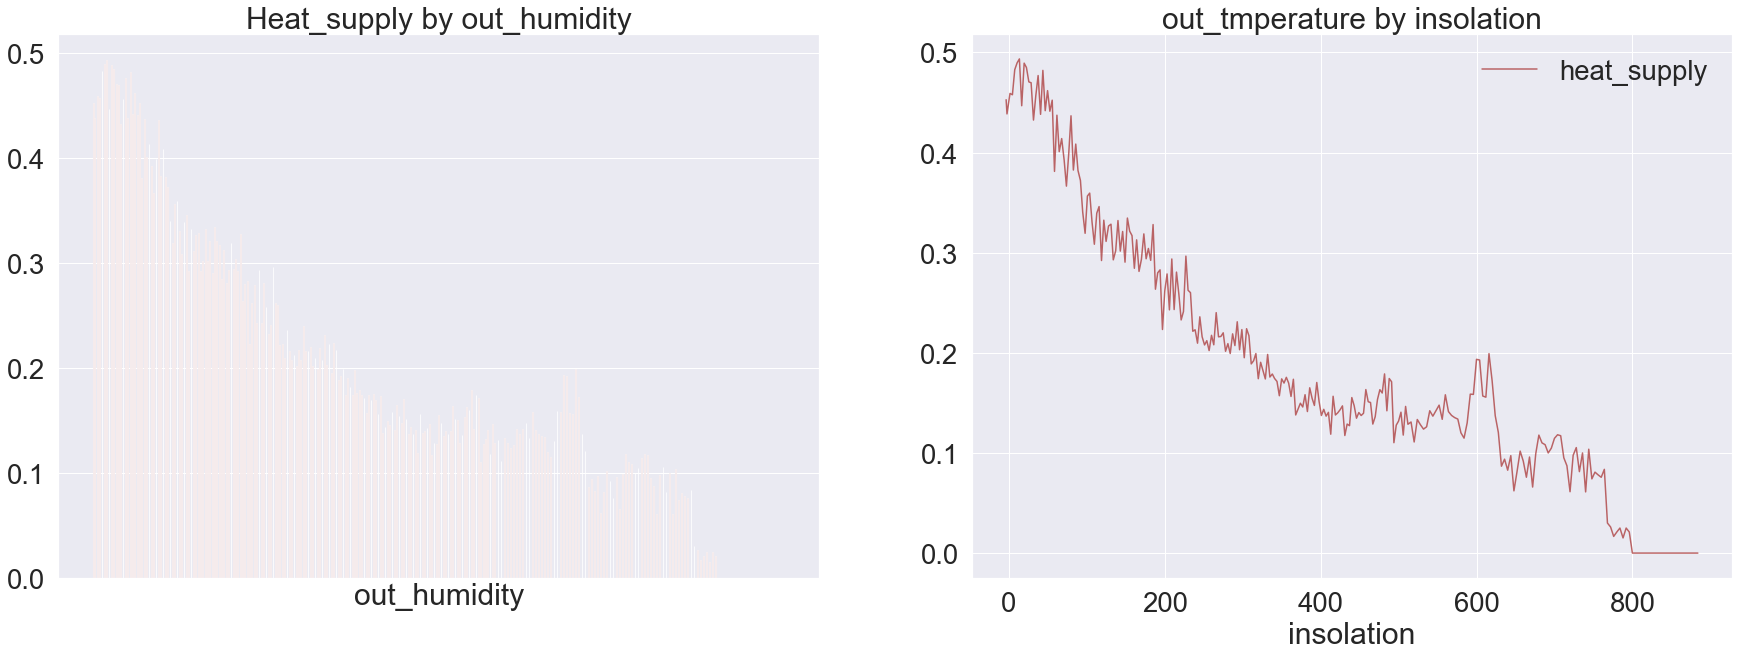

In [74]:
f, ax = plt.subplots(1, 2, figsize = (30,10))

x = farm_df[['insolation', 'heat_supply']].groupby(['insolation'], as_index = True).mean().index
y = farm_df[['insolation', 'heat_supply']].groupby(['insolation'], as_index = True).mean().values
y = np.array(y)
y = np.reshape(y,len(y))

ax[0].bar(x, y, color='brown', label='Demand', alpha=0.8, width=1)
ax[0].axes.xaxis.set_ticks([])
ax[0].set_title("Heat_supply by out_humidity")
ax[0].set_xlabel("out_humidity")

farm_df[['insolation', 'heat_supply']].groupby(['insolation'], as_index = True).mean().plot(ax = ax[1], color = ['brown'], alpha = 0.7)
ax[1].set_title("out_tmperature by insolation")

어느정도 이상치들이 정리된 후 모습입니다.  
일사량이 높을수록 열 공급량은 줄어드는 경향을 보입니다.  

지금까지 기후/기상(기온,습도,일사량)에 따른 열 공급량 변화를 살펴보았습니다.  
그래프로 보았을때는 3가지 지표 모두 열 공급량과 일종의 관계를 맺는것으로 보입니다.  

### 확증적 데이터 분석(CDA, Confirmatory Data Analysis)

지금부터는 통계적 가설을 세우고 이를 수집된 데이터로 검증, 확인하며 사용하는 CDA과정을 거쳐보겠습니다.  
이 부분은 앞서 1차대회 기상/기온 데이터에서 사용한 방법을 활용해보겠습니다.  

#### 1.결과지표와 상관계수가 높은 데이터는 강한 상간관계를 가진다. 고로, 비례 혹은 반비례의
#### 관계가 있을 확률이 높고 이는 모델학습에 사용할만한 중요한 데이터일 수 있다.

#### 2.귀무가설과 대립가설  

#### Pearson 계수  

0.0~0.1: 거의 관계없음  

0.1~0.2: 약한 양의 상관관계  

0.2~0.4: 보통의 양의 상관관계  

0.4~0.6: 비교적 강한 양의 상관관계  

0.6~0.8: 강한 양의 관계  

0.8~1.0: 매우 강한 양의 상관관계   

(Rea, L. M., & Parker, R.A. (2005). Designing & Conducting Survey Research A Comprehensive Guide (3rd Edition). San Francisco, CA: Jossey-Bass.)
위의 통계분석 조사 자료를 참고하면 위와 같은 Pearson 분류 기준을 확인할 수 있습니다.  
이 중Pearson 계수 절댓값 0.4 이상의 비교적 강한 음,양의 관계를 가지는 데이터를 추출 기준을 삼겠습니다.

#### P_value 검증

1) 귀무가설
: 두 변수간 아무 영향, 관계가 없다고 가정합니다.(p_value가 유의수준a보다 큰 경우)
    
2) 대립가설
: 두 변수간 일종의 관계, 이유가 있다고 가정합니다.(p_value가 유의수준a보다 작은 경우)

p_value 검증과 관련된 통계적 가설입니다. 이때 유의수준은 사건이 우연히 일어날 확률을 의미하고  
p_value가 a(0.1)보다 작다는 것은 어떤 사건이 우연히 일어날 확률이 10%보다 작다는 뜻입니다.

a를 0.05로 두고 p_value가 0.05보다 작으면 귀무가설을 기각하고 대립가설을 택하겠습니다.


1차대회와는 살짝 다르게 pearson 계수를 0.4이상으로 고려해보겠습니다.


### 상관계수 분석

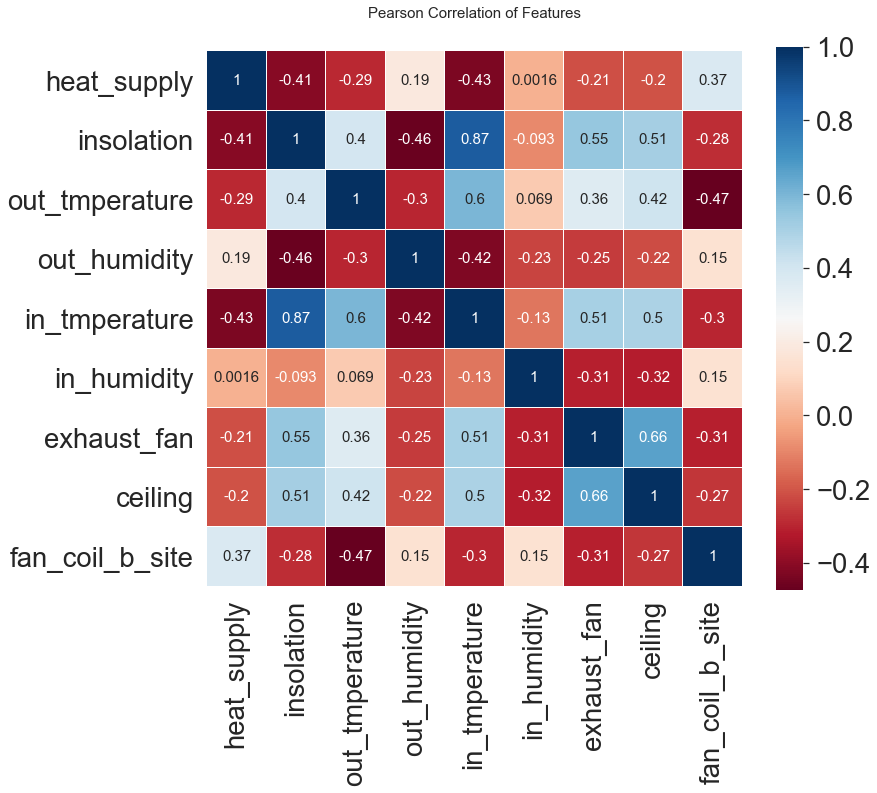

In [130]:
heatmap_data = farm_df[["heat_supply","insolation","out_tmperature",
                    "out_humidity",'in_tmperature','in_humidity',"exhaust_fan","ceiling","fan_coil_b_site"
                    ]]

colormap = plt.cm.RdBu
plt.figure(figsize = (12, 10))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square = True,
           cmap = colormap, linecolor = 'white', annot = True, annot_kws={"size":15})


del heatmap_data

먼저 제공된 데이터들의 상관계수를 분석해 보았습니다.  
외부 기온, 외부 습도, 배기팬과 천장, 팬 코일이 열 공급량과  
보통의 상관관계(0.2이상)를  
일사량과 내부 기온이 비교적 강한 상관관계를 보입니다.  


In [21]:
import scipy.stats as stats

def get_p_value(data_list):
    heat_p_values = []
    heat_total_values = []
    
    for i in data_list:
        heat_p_value = stats.pearsonr(farm_df['heat_supply'],farm_df[i])
       
        print("heat_supply 와 {0}의 pearson 계수: {1:0.2f}, p_value: {2:0.4f}".format(i,farm_df[["heat_supply",i]].corr(method = 'pearson')[i][0]
        ,heat_p_value[1]))
        
        # 유의수준 alpha 값: 0.05(5%)이하 check
        if heat_p_value[1] <= 0.05:
            heat_p_values.append(i)
    
    # perason 계수 check(강한 상관관계를 가지는)
    for i in heat_p_values:
        if (farm_df[["heat_supply",i]].corr(method = 'pearson')[i][0] <= -0.4) or (farm_df[["heat_supply",i]].corr(method = 'pearson')[i][0] >=0.4):
                heat_total_values.append(i)
    
    print()
    print("heat_supply와 p_value 귀무가설을 기각하고(통계적으로 결과값 변수와 유의미한 상과관계를 가지는)\n강한 상관관계를 가지는 변수들:",end= '')
            
    for i in range(len(heat_total_values)):
        if i == len(heat_total_values) -1:
            print(heat_total_values[i])
            continue
        print(heat_total_values[i],end= ',')
    
    print()
    return

get_p_value(["index","yy","mm","dd","hh","nn","insolation","out_tmperature",
                    "out_humidity",'wind_speed','wind_direction','in_tmperature','in_humidity',"shield_light_h","shield_tmperature_h",
                    "shield_energy_h","shield_energy_v","exhaust_fan","ceiling","floating_fan","fan_coil_b_site","ventilation_temperature_control",
                    "heating_temperature_set_up"])


heat_supply 와 index의 pearson 계수: -0.01, p_value: 0.0000
heat_supply 와 yy의 pearson 계수: 0.01, p_value: 0.0480
heat_supply 와 mm의 pearson 계수: -0.01, p_value: 0.0011
heat_supply 와 dd의 pearson 계수: 0.01, p_value: 0.0000
heat_supply 와 hh의 pearson 계수: -0.06, p_value: 0.0000
heat_supply 와 nn의 pearson 계수: -0.00, p_value: 0.3253
heat_supply 와 insolation의 pearson 계수: -0.41, p_value: 0.0000
heat_supply 와 out_tmperature의 pearson 계수: -0.29, p_value: 0.0000
heat_supply 와 out_humidity의 pearson 계수: 0.19, p_value: 0.0000
heat_supply 와 wind_speed의 pearson 계수: -0.09, p_value: 0.0000
heat_supply 와 wind_direction의 pearson 계수: 0.06, p_value: 0.0000
heat_supply 와 in_tmperature의 pearson 계수: -0.43, p_value: 0.0000
heat_supply 와 in_humidity의 pearson 계수: 0.00, p_value: 0.5582
heat_supply 와 shield_light_h의 pearson 계수: -0.38, p_value: 0.0000
heat_supply 와 shield_tmperature_h의 pearson 계수: -0.36, p_value: 0.0000
heat_supply 와 shield_energy_h의 pearson 계수: -0.39, p_value: 0.0000
heat_supply 와 shield_energy_v의 pearson 계수:

CDA 가설을 통해서 나온 변수들입니다.  
기상, 기온과 관련해서는 insolation과 in_temperature값이 나왔습니다.  
이번 대회에서 중요한것은 기상청의 기상/기온 데이터의 활용을 통한 절감모델 구축입니다.  
고로, insolation(일사량)과 연관이 되는 SolarZA(기상청 데이터, 태양청천각),  
in_temperature(내부 온도)와 연관이 되는 Ground-TA(기상청 데이터, 지상온도),  
insitu-HM(기상청 데이터, 지상온도),  ESR(기상청 데이터,대기외 일사량)을 절감모델에 추가해  
적용해보겠습니다.  

(1차 대회에서 CDA를 통해 지상온도(Ground-TA)와 유의미한 영향을 가지는 데이터로   
ESR(대기외 일사량), insitu-HM(습도)를 추출했었습니다.  
위 두 지표는 그래프로도, 모델 검증을 통해서도 확인된 지표입니다.    
고로, 절감모델에 ESR과 insitu-HM을 적용해서 사용하겠습니다.)

### 복합제어 시스템 모델, 절감 모델 데이터 생성

기존 스마트팜 데이터로는 복합 제어 시스템 모델을,  
기상청의 기상/기후 데이터를 활용한 데이터로는 절감 모델을 생성할 것입니다.  
이에 따라 복합제어 시스템 모델 train 데이터 farm_X_train1,  
절감 모델 train 데이터 farm_X_train2를 만들고 모델에 적용하겠습니다.  

In [ ]:
# 기상청 데이터 import
# Degree_Forcast 위치에 2020년~2021년 기상데이터.csv 들이 있어야 합니다.(다른 csv있으면 안됨)


all_data = []
all_files = glob.glob(os.path.join("C:\\Users\\USER\\Kaggle\\Degree_Forcast","*.csv"))

for file in all_files:
    df = pd.read_csv(file)
    if df.shape[1] != 44:
        continue
    
        
    df.columns = ["YearMonthDayHourMinute","STN","Lon","Lat","Surface-TA","STN_area","Band2",
                    "Band3","Band4","Band5","Band6","Band7","Band8","Band9","Band10","Band11",
                     "Band12","Band13","Band14","Band15","Band16","30daysBand3",
                    "30daysBand13","GK2A-LST","SolarZA","SateZA","ESR","Height","LandType",
                     "Ground-TA","insitu-HM","insitu-TD","insitu-TG","insitu-TED0.05","insitu-TED0.1",
                     "insitu-TED0.2","insitu-TED0.3","insitu-TED0.5","insitu-TED1.0",
                     "insitu-TED1.5","insitu-TED3.0","insitu-TED5.0","insitu-PA","insitu-PS"]


    # 데이터 결측치 처리
    df = df[ df['Surface-TA'] != -999]
    df = df[ df['Ground-TA'] != -999]
    
    
    df = df[['YearMonthDayHourMinute',"insitu-TD","insitu-TG",
       ,'SolarZA','ESR','Lon','Lat',
       'insitu-HM','LandType','STN','Surface-TA','Ground-TA']]

    
    all_data.append(df)

# all_data_tmp = map(pd.read_csv, all_files)
df = pd.concat(all_data, axis = 0,ignore_index=True)

In [ ]:
df = df[['YearMonthDayHourMinute',
       'SateZA','Height','SolarZA','ESR','STN',
       'insitu-HM','LandType','STN','Surface-TA','Ground-TA']]

In [ ]:
# 결측치 처리

df = df.dropna(axis = 0)

In [ ]:
for i in range(13):
    df.loc[ ((df['YearMonthDayHourMinute']%100000000)//1000000 == i),'Month'] = i

In [ ]:
# 스마트팜 데이터와 시간 맞추기

df = df[ (df['Month']>=11)| (df['Month']<=3)]

In [ ]:
df.to_csv('C:\\Users\\USER\\Kaggle\\Degree_Forcast\\weather_df.csv')

In [58]:
df = pd.read_csv('C:\\Users\\USER\\Kaggle\\Degree_Forcast\\weather_df.csv')

#### 스마트팜 위치와 기상청 데이터 위치 맞추기

In [35]:
df = df[(df['Lat']>= 35.01)&(df['Lat']<= 35.41) &(df['Lon']>= 127.92) &(df['Lon']<= 128.32)]

스마트팜의 위치는 위도: 35.21, 경도: 128.12입니다. 이에 맞게 상하로 0.2 위도, 경도를 주어  
구역을 설정해주었습니다.

In [36]:
df_whole = deepcopy(df)

In [ ]:
#### 시간 특성 부여(Month, Hour)

In [37]:
for i in range(13):
    df.loc[ ((df['YearMonthDayHourMinute']%100000000)//1000000 == i),'Month'] = i

In [38]:
# train용으로 11~2월 데이터

df = df[ (df['Month']>=11)| (df['Month']<=2)]

In [39]:
df = df[ (df['Month']>=11)| (df['Month']<=2)]
weather_df = deepcopy(df)

In [40]:
# 시간 특성 부여
for i in range(24):
    weather_df.loc[ ((weather_df['YearMonthDayHourMinute']%10000)//100 == i),'Hour'] = i

In [48]:
for i in range(32):
    weather_df.loc[ ((weather_df['YearMonthDayHourMinute']%1000000)//10000 == i),'Day'] = i

In [41]:
weather_df = weather_df.dropna(axis = 0)
weather_df


,YearMonthDayHourMinute,SateZA,Height,SolarZA,ESR,STN,Lon,Lat,insitu-HM,LandType,STN.1,Surface-TA,Ground-TA,Month,Hour
0,202001010000,41.02545,29.35,164.92210,-9.49253,192.0,128.04004,35.16378,54.9,3.0,192.0,-3.3,-6.3,1.0,0.0
4,202001010000,41.10588,16.78,164.92516,-9.49236,974.0,128.15605,35.24435,31.7,2.0,974.0,-2.5,-3.1,1.0,0.0
5,202001010010,41.02545,29.35,166.09703,-9.49253,192.0,128.04004,35.16378,53.0,3.0,192.0,-3.3,-6.0,1.0,0.0
6,202001010010,41.20687,14.10,166.06371,-9.49199,263.0,128.28812,35.32258,75.3,2.0,263.0,-0.2,-7.2,1.0,0.0
10,202001010010,41.10588,16.78,166.08386,-9.49236,974.0,128.15605,35.24435,30.0,2.0,974.0,-2.5,-2.9,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234025,202112102340,41.20687,14.10,163.49947,-9.05243,263.0,128.28812,35.32258,92.2,2.0,263.0,4.0,2.6,12.0,23.0
234030,202112102340,41.10588,16.78,163.48225,-9.04862,974.0,128.15605,35.24435,96.9,2.0,974.0,3.0,2.1,12.0,23.0
234032,202112102350,41.02545,29.35,164.85004,-9.04531,192.0,128.04004,35.16378,95.6,3.0,192.0,3.4,3.4,12.0,23.0
234033,202112102350,41.20687,14.10,164.85379,-9.05243,263.0,128.28812,35.32258,93.0,2.0,263.0,3.9,2.5,12.0,23.0


In [46]:
farm_df2['Day_Hour'] = farm_df2['dd']*100 + farm_df2['hh']

In [49]:
weather_df['Day_Hour'] = weather_df['Day']*100 + weather_df['Hour']

In [55]:
farm_df2 = farm_df2.sort_values(by = ['mm','dd'])

In [61]:
farm_df2 = farm_df2[~ ((farm_df2['mm']==12) &(farm_df2['dd']>=11)  )]

In [64]:
farm_df2

,index,yy,mm,dd,hh,nn,insolation,out_tmperature,out_humidity,wind_speed,...,shield_energy_h,shield_energy_v,exhaust_fan,ceiling,floating_fan,fan_coil_b_site,ventilation_temperature_control,heating_temperature_set_up,heat_supply,Day_Hour
47520,47521,2022,1,1,0,0,-2.9,-2.5,40,0.9,...,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.4,100
47521,47522,2022,1,1,0,1,-3.0,-2.5,41,0.9,...,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.5,100
47522,47523,2022,1,1,0,2,-3.0,-2.6,41,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.5,100
47523,47524,2022,1,1,0,3,-3.1,-2.6,42,0.4,...,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.4,100
47524,47525,2022,1,1,0,4,-3.1,-2.6,42,0.4,...,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.5,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,21596,2021,12,10,23,55,-2.8,4.4,89,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.1,1023
21596,21597,2021,12,10,23,56,-3.0,4.4,89,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.1,1023
21597,21598,2021,12,10,23,57,-3.2,4.4,89,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.6,1023
21598,21599,2021,12,10,23,58,-3.2,4.4,89,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.7,1023


In [65]:
weather_df

,YearMonthDayHourMinute,SateZA,Height,SolarZA,ESR,STN,Lon,Lat,insitu-HM,LandType,STN.1,Surface-TA,Ground-TA,Month,Hour,Day,Day_Hour
0,202001010000,41.02545,29.35,164.92210,-9.49253,192.0,128.04004,35.16378,54.9,3.0,192.0,-3.3,-6.3,1.0,0.0,1.0,100.0
4,202001010000,41.10588,16.78,164.92516,-9.49236,974.0,128.15605,35.24435,31.7,2.0,974.0,-2.5,-3.1,1.0,0.0,1.0,100.0
5,202001010010,41.02545,29.35,166.09703,-9.49253,192.0,128.04004,35.16378,53.0,3.0,192.0,-3.3,-6.0,1.0,0.0,1.0,100.0
6,202001010010,41.20687,14.10,166.06371,-9.49199,263.0,128.28812,35.32258,75.3,2.0,263.0,-0.2,-7.2,1.0,0.0,1.0,100.0
10,202001010010,41.10588,16.78,166.08386,-9.49236,974.0,128.15605,35.24435,30.0,2.0,974.0,-2.5,-2.9,1.0,0.0,1.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234025,202112102340,41.20687,14.10,163.49947,-9.05243,263.0,128.28812,35.32258,92.2,2.0,263.0,4.0,2.6,12.0,23.0,10.0,1023.0
234030,202112102340,41.10588,16.78,163.48225,-9.04862,974.0,128.15605,35.24435,96.9,2.0,974.0,3.0,2.1,12.0,23.0,10.0,1023.0
234032,202112102350,41.02545,29.35,164.85004,-9.04531,192.0,128.04004,35.16378,95.6,3.0,192.0,3.4,3.4,12.0,23.0,10.0,1023.0
234033,202112102350,41.20687,14.10,164.85379,-9.05243,263.0,128.28812,35.32258,93.0,2.0,263.0,3.9,2.5,12.0,23.0,10.0,1023.0


In [66]:
farm_df2.groupby(['hh']).count()

,index,yy,mm,dd,nn,insolation,out_tmperature,out_humidity,wind_speed,wind_direction,...,shield_energy_h,shield_energy_v,exhaust_fan,ceiling,floating_fan,fan_coil_b_site,ventilation_temperature_control,heating_temperature_set_up,heat_supply,Day_Hour
hh,,,,,,,,,,,,,,,,,,,,,
0,4348,4348,4348,4348,4348,4348,4348,4348,4348,4348,...,4348,4348,4348,4348,4348,4348,4348,4348,4348,4348
1,4340,4340,4340,4340,4340,4340,4340,4340,4340,4340,...,4340,4340,4340,4340,4340,4340,4340,4340,4340,4340
2,4263,4263,4263,4263,4263,4263,4263,4263,4263,4263,...,4263,4263,4263,4263,4263,4263,4263,4263,4263,4263
3,4318,4318,4318,4318,4318,4318,4318,4318,4318,4318,...,4318,4318,4318,4318,4318,4318,4318,4318,4318,4318
4,4338,4338,4338,4338,4338,4338,4338,4338,4338,4338,...,4338,4338,4338,4338,4338,4338,4338,4338,4338,4338
5,4440,4440,4440,4440,4440,4440,4440,4440,4440,4440,...,4440,4440,4440,4440,4440,4440,4440,4440,4440,4440
6,4415,4415,4415,4415,4415,4415,4415,4415,4415,4415,...,4415,4415,4415,4415,4415,4415,4415,4415,4415,4415
7,4380,4380,4380,4380,4380,4380,4380,4380,4380,4380,...,4380,4380,4380,4380,4380,4380,4380,4380,4380,4380
8,4409,4409,4409,4409,4409,4409,4409,4409,4409,4409,...,4409,4409,4409,4409,4409,4409,4409,4409,4409,4409


In [ ]:
#### 스마트팜 데이터(smart_Farm)에 기상청 데이터(weather) 추가해주기(For 절감 모델)

In [67]:
weather_df.groupby(['Hour']).count().min()

YearMonthDayHourMinute    2367
SateZA                    2367
Height                    2367
SolarZA                   2367
ESR                       2367
STN                       2367
Lon                       2367
Lat                       2367
insitu-HM                 2367
LandType                  2367
STN.1                     2367
Surface-TA                2367
Ground-TA                 2367
Month                     2367
Day                       2367
Day_Hour                  2367
dtype: int64

In [68]:
# 기상청 데이터는 시간별로 최소 2367개의 데이터를 가집니다.
# 스마트팜 데이터는 대략 5천개별 데이터를 가지는데, 두 데이터를 합쳐주려면
# 최소 공통데이터인 2367개씩 묶어서 합쳐줍니다.
# 두 데이터의 순서는 시간별로 sort되어 있습니다.

from pandas import DataFrame

new_farm_df2 = DataFrame()
data_tmp = [[] for _ in range(len(['in_tmperature','in_humidity',"exhaust_fan","ceiling","fan_coil_b_site",'new_SolarZA',
              'new_Ground-TA','new_insitu-HM','new_ESR','hh','heat_supply']))]
idx = 0

for data in ['SolarZA','Ground-TA','ESR','insitu-HM']:
    for i in range(24):
        data_tmp[idx].append(weather_df[weather_df['Hour'] == i][data][:2368])
    idx += 1


for data in ['hh','in_tmperature','in_humidity',"exhaust_fan","ceiling","fan_coil_b_site",'heat_supply']:
    for i in range(24):
        data_tmp[idx].append(farm_df2[farm_df2['hh'] == i][data][:2368])
    idx += 1

idx = 0
for data in ['new_SolarZA','new_Ground-TA','new_ESR','new_insitu-HM','hh','in_tmperature','in_humidity',"exhaust_fan","ceiling","fan_coil_b_site",'heat_supply']:
    tmp = pd.concat(data_tmp[idx], axis = 0,ignore_index=True)
    new_farm_df2[data] = tmp
    idx += 1
    
    
new_farm_df2

,new_SolarZA,new_Ground-TA,new_ESR,new_insitu-HM,hh,in_tmperature,in_humidity,exhaust_fan,ceiling,fan_coil_b_site,heat_supply
0,164.92210,-6.3,-9.49253,54.9,0,18.2,73.1,0.0,0.0,1.0,0.4
1,164.92516,-3.1,-9.49236,31.7,0,18.2,72.7,0.0,0.0,1.0,0.5
2,166.09703,-6.0,-9.49253,53.0,0,18.3,72.6,0.0,0.0,1.0,0.5
3,166.06371,-7.2,-9.49199,75.3,0,18.3,73.1,0.0,0.0,1.0,0.4
4,166.08386,-2.9,-9.49236,30.0,0,18.2,73.4,0.0,0.0,1.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...
56826,160.36407,3.8,-9.05092,92.6,23,18.4,65.3,0.0,0.0,1.0,0.7
56827,160.32445,3.7,-9.04733,95.1,23,18.5,64.9,0.0,0.0,0.0,0.9
56828,161.91101,4.0,-9.04421,94.5,23,18.3,66.6,0.0,0.0,0.0,0.5
56829,161.96349,3.6,-9.05092,92.5,23,18.3,66.2,0.0,0.0,0.0,0.0


In [71]:
new_farm_df2

,new_SolarZA,new_Ground-TA,new_ESR,new_insitu-HM,hh,in_tmperature,in_humidity,exhaust_fan,ceiling,fan_coil_b_site,heat_supply
0,164.92210,-6.3,-9.49253,54.9,0,18.2,73.1,0.0,0.0,1.0,0.4
1,164.92516,-3.1,-9.49236,31.7,0,18.2,72.7,0.0,0.0,1.0,0.5
2,166.09703,-6.0,-9.49253,53.0,0,18.3,72.6,0.0,0.0,1.0,0.5
3,166.06371,-7.2,-9.49199,75.3,0,18.3,73.1,0.0,0.0,1.0,0.4
4,166.08386,-2.9,-9.49236,30.0,0,18.2,73.4,0.0,0.0,1.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...
56826,160.36407,3.8,-9.05092,92.6,23,18.4,65.3,0.0,0.0,1.0,0.7
56827,160.32445,3.7,-9.04733,95.1,23,18.5,64.9,0.0,0.0,0.0,0.9
56828,161.91101,4.0,-9.04421,94.5,23,18.3,66.6,0.0,0.0,0.0,0.5
56829,161.96349,3.6,-9.05092,92.5,23,18.3,66.2,0.0,0.0,0.0,0.0


In [69]:
farm_X_train1 = farm_df[['hh',"insolation","out_tmperature",
                    "out_humidity",'in_tmperature','in_humidity',"exhaust_fan","ceiling","fan_coil_b_site"
                    ]]

farm_y_train1 = farm_df[["heat_supply"]]

In [73]:
farm_X_train2 = new_farm_df2[['hh','in_tmperature','in_humidity',"exhaust_fan","ceiling","fan_coil_b_site",
                    'new_SolarZA','new_Ground-TA','new_insitu-HM','new_ESR']]

farm_y_train2 = new_farm_df2[["heat_supply"]]

#### Data Normalization

In [74]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
farm_X_train_scaled1 = minmax_scaler.fit_transform(farm_X_train1)
farm_X_train_scaled2 = minmax_scaler.fit_transform(farm_X_train2)


### 모델 구축 및 학습

지금까지 데이터 분석기법 및 방법에 대한 프로그램이였습니다.  
이제부터는 실제 모델을 구축하고 train데이터들을 전처리 및 정리해 학습하는 과정을  
거칠것입니다.  
위에서 정리한 기법들을 차례로 적용하기 위해 전체 데이터를 다시 한번 import하고  
모델을 학습, 평가까지 해보겠습니다.  

#### 모델 Specification
- Cross Validation(10-fold)  
- Models: lightgbm, xgboost, svr, ridge, random forest, gradient boosting  
- Blending: 좋은 성능의 prediction을 위해 학습된 모델들을 결합해 사용   

In [76]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA


kf = KFold(n_splits=10, shuffle = True, random_state = 42)
farm_labels1 = farm_y_train1['heat_supply'].reset_index(drop=True)
farm_labels2= farm_y_train2['heat_supply'].reset_index(drop=True)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

def cv_rmse(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv=kf))
    
    return (rmse)

In [77]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# lightgbm
farm_lightgbm1 = LGBMRegressor(
    objective = 'regression',
    num_leaves = 6,
    learning_rate = 0.01,
    n_estimators = 7000,
    max_bin = 200,
    bagging_fraction = 0.8,
    bagging_freq = 4,
    bagging_seed = 8,
    feature_fraction = 0.2,
    feature_fraction_seed = 8,
    min_sum_hessian_in_leaf = 11,
    verbose = -1,
    random_state = 42
)

farm_lightgbm2 = LGBMRegressor(
    objective = 'regression',
    num_leaves = 6,
    learning_rate = 0.01,
    n_estimators = 7000,
    max_bin = 200,
    bagging_fraction = 0.8,
    bagging_freq = 4,
    bagging_seed = 8,
    feature_fraction = 0.2,
    feature_fraction_seed = 8,
    min_sum_hessian_in_leaf = 11,
    verbose = -1,
    random_state = 42
)


# XGBoost Regressor
farm_xgboost1 = XGBRegressor(
    learning_rate = 0.01,
    n_estimators = 6000,
    max_depth = 4,
    min_child_weight = 0,
    gamma = 0.6,
    subsample = 0.7,
    colsample_bytree = 0.7,
    objective = 'reg:linear',
    nthread = -1,
    scale_pos_weight = 1,
    seed = 27,
    reg_alpha = 0.00006,
    random_state = 42
)

farm_xgboost2 = XGBRegressor(
    learning_rate = 0.01,
    n_estimators = 6000,
    max_depth = 4,
    min_child_weight = 0,
    gamma = 0.6,
    subsample = 0.7,
    colsample_bytree = 0.7,
    objective = 'reg:linear',
    nthread = -1,
    scale_pos_weight = 1,
    seed = 27,
    reg_alpha = 0.00006,
    random_state = 42
)


#Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1,
               0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]

farm_ridge1 = make_pipeline(RobustScaler(), RidgeCV(alphas = ridge_alphas, cv = kf))
farm_ridge2 = make_pipeline(RobustScaler(), RidgeCV(alphas = ridge_alphas, cv = kf))


farm_svr1 = make_pipeline(RobustScaler(), SVR(C=20, epsilon = 0.008, gamma = 0.0003))
farm_svr2 = make_pipeline(RobustScaler(), SVR(C=20, epsilon = 0.008, gamma = 0.0003))

farm_gbr1 = GradientBoostingRegressor(
    n_estimators = 6000,
    learning_rate = 0.01,
    max_depth = 4,
    max_features = 'sqrt',
    min_samples_leaf = 15,
    min_samples_split = 10,
    loss = 'huber',
    random_state = 42
)
farm_gbr2 = GradientBoostingRegressor(
    n_estimators = 6000,
    learning_rate = 0.01,
    max_depth = 4,
    max_features = 'sqrt',
    min_samples_leaf = 15,
    min_samples_split = 10,
    loss = 'huber',
    random_state = 42
)

farm_rf1 = RandomForestRegressor(
    n_estimators = 1200,
    max_depth = 15,
    min_samples_split = 5,
    min_samples_leaf = 5,
    max_features = None,
    oob_score = True,
    random_state = 42
)

farm_rf2 = RandomForestRegressor(
    n_estimators = 1200,
    max_depth = 15,
    min_samples_split = 5,
    min_samples_leaf = 5,
    max_features = None,
    oob_score = True,
    random_state = 42
)


farm_stack_gen1 = StackingCVRegressor(
    regressors = (farm_xgboost1, farm_lightgbm1, farm_svr1, farm_ridge1, farm_gbr1, farm_rf1),
    meta_regressor = farm_xgboost1,
    use_features_in_secondary = True
)
farm_stack_gen2 = StackingCVRegressor(
    regressors = (farm_xgboost2, farm_lightgbm2, farm_svr2, farm_ridge2, farm_gbr2, farm_rf2),
    meta_regressor = farm_xgboost2,
    use_features_in_secondary = True
)


In [78]:
scores = {}

score_farm1 = cv_rmse(farm_lightgbm1, farm_X_train_scaled1, farm_labels1)
print("lightgbm_farm1: {:.4f} ({:.4f})".format(score_farm1.mean(), score_farm1.std()))
scores['lgb_fram1'] = (score_farm1.mean(), score_farm1.std())


score_farm2 = cv_rmse(farm_lightgbm2, farm_X_train_scaled2, farm_labels2)
print("lightgbm_farm2: {:.4f} ({:.4f})".format(score_farm2.mean(), score_farm2.std()))
scores['lgb_farm2'] = (score_farm2.mean(), score_farm2.std())

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] featu

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] featu

In [627]:

score_farm1 = cv_rmse(farm_gbr1, farm_X_train_scaled1, farm_labels1)
print("gbr_farm1: {:.4f} ({:.4f})".format(score_farm1.mean(), score_farm1.std()))
scores['gbr_farm1'] = (score_farm1.mean(), score_farm1.std())

score_farm2 = cv_rmse(farm_gbr2, farm_X_train_scaled2, farm_labels2)
print("gbr_farm2: {:.4f} ({:.4f})".format(score_farm2.mean(), score_farm2.std()))
scores['gbr_farm2'] = (score_farm2.mean(), score_farm2.std())




[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] featu

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] featu

In [512]:

score_farm1 = cv_rmse(farm_svr1, farm_X_train_scaled1, farm_labels1)
print("svr_farm1 {:.4f} ({:.4f})".format(score_farm1.mean(), score_farm1.std()))
scores['svr_farm1'] = (score_farm1.mean(), score_farm1.std())

score_farm2 = cv_rmse(farm_svr2, farm_X_train_scaled2, farm_labels2)
print("svr_farm2: {:.4f} ({:.4f})".format(score_farm2.mean(), score_farm2.std()))
scores['svr_farm2'] = (score_farm2.mean(), score_farm2.std())

[05:02:17] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:02] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[05:35:30] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:17] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:08:14] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:11] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:42:22] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objecti

KeyboardInterrupt: 

In [ ]:

score_farm1 = cv_rmse(farm_ridge1, farm_X_train_scaled1, farm_labels1)
print("ridge_farm1: {:.4f} ({:.4f})".format(score_farm1.mean(), score_farm1.std()))
scores['ridge_farm1'] = (score_farm1.mean(), score_farm1.std())

score_farm2 = cv_rmse(farm_ridge2, farm_X_train_scaled2, farm_labels2)
print("ridge_farm2: {:.4f} ({:.4f})".format(score_farm2.mean(), score_farm2.std()))
scores['ridge_farm2'] = (score_farm2.mean(), score_farm2.std())

In [ ]:

score_farm1 = cv_rmse(farm_rf1, farm_X_train_scaled1, farm_labels1)
print("rf_surface: {:.4f} ({:.4f})".format(score_farm1.mean(), score_farm1.std()))
scores['rf_suface'] = (score_farm1.mean(), score_farm1.std())

score_farm2 = cv_rmse(farm_rf2, farm_X_train_scaled2, farm_labels2)
print("rf_ground: {:.4f} ({:.4f})".format(score_farm2.mean(), score_farm2.std()))
scores['rf_ground'] = (score_farm2.mean(), score_farm2.std())


In [287]:

score_farm1 = cv_rmse(farm_xgboost1, farm_X_train_scaled1, farm_labels1)
print("xgboost_farm1: {:.4f} ({:.4f})".format(score_farm1.mean(), score_farm1.std()))
scores['xgboost_farm1'] = (score_farm1.mean(), score_farm1.std())

score_farm2 = cv_rmse(farm_xgboost2, farm_X_train_scaled2, farm_labels2)
print("xgboost_farm2: {:.4f} ({:.4f})".format(score_farm2.mean(), score_farm2.std()))
scores['xgboost_farm2'] = (score_farm2.mean(), score_farm2.std())




ridge_surface: 4.6127 (0.0194)


Exception ignored in: <function Dataset.__del__ at 0x0000022F9DE884C8>
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\basic.py", line 1120, in __del__
    try:
KeyboardInterrupt: 


KeyboardInterrupt: 

In [141]:
farm_stack_gen_model1= farm_stack_gen1.fit(np.array(farm_X_train_scaled1), np.array(farm_labels1))
farm_stack_gen_model2= farm_stack_gen2.fit(np.array(farm_X_train_scaled2), np.array(farm_labels2))

[21:51:08] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:13] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:19] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:25] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:51:31] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Curre

In [79]:
farm_lightgbm_model1 = farm_lightgbm1.fit((farm_X_train_scaled1), (farm_labels1))
farm_lightgbm_model2 = farm_lightgbm2.fit((farm_X_train_scaled2), (farm_labels2))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [216]:
farm_xgboost_model1 = farm_xgboost1.fit(farm_X_train_scaled1, farm_labels1)
farm_xgboost_model2 = farm_xgboost2.fit(farm_X_train_scaled2, farm_labels2)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [654]:
farm_svr_model1 = farm_svr1.fit(farm_X_train_scaled1, farm_labels1)
farm_svr_model2 = farm_svr2.fit(farm_X_train_scaled2, farm_labels2)

[17:59:20] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:12:40] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [134]:
farm_gbr_model1 = farm_gbr1.fit(farm_X_train_scaled1, farm_labels1)
farm_gbr_model2 = farm_gbr2.fit(farm_X_train_scaled2, farm_labels2)

In [135]:
farm_ridge_model1 = farm_ridge1.fit(farm_X_train_scaled1, farm_labels1)
farm_ridge_model2 = farm_ridge2.fit(farm_X_train_scaled2, farm_labels2)

In [136]:
farm_rf_model1 = farm_rf1.fit(farm_X_train_scaled1, farm_labels1)
farm_rf_model2 = farm_rf2.fit(farm_X_train_scaled2, farm_labels2)

In [142]:
def farm_blended_predictions1(X):
    return (
    (0.1 * farm_xgboost_model1.predict(X)) +
    (0.1 * farm_lightgbm_model1.predict(X)) +
    (0.2 * farm_svr_model1.predict(X)) +
    (0.1 * farm_ridge_model1.predict(X)) +
    (0.1 * farm_gbr_model1.predict(X)) +
    (0.05 * farm_rf_model1.predict(X)) +
    (0.35 * farm_stack_gen_model1.predict(np.array(X)))
    )

def farm_blended_predictions2(X):
    return (
    (0.1 * farm_xgboost_model2.predict(X)) +
    (0.1 * farm_lightgbm_model2.predict(X)) +
    (0.2 * farm_svr_model2.predict(X)) +
    (0.1 * farm_ridge_model2.predict(X)) +
    (0.1 * farm_gbr_model2.predict(X)) +
    (0.05 * farm_rf_model2.predict(X)) +
    (0.35 * farm_stack_gen_model2.predict(np.array(X)))
    )


In [143]:
farm_blended_score1 = rmsle(farm_labels1, farm_blended_predictions1(farm_X_train_scaled1))
scores['farm_blended_score1'] = (farm_blended_score1, 0)
print('RMSLE score on train data:{}'.format(farm_blended_score1))

RMSLE score on train data:1.7546489121196067


In [144]:
farm_blended_score2 = rmsle(farm_labels2, farm_blended_predictions2(farm_X_train_scaled2))
scores['farm_blended_score2'] = (farm_blended_score2, 0)
print('RMSLE score on train data:{}'.format(farm_blended_score2))

RMSLE score on train data:0.5229154538074816


### 모델 예측 및 평가

In [81]:
farm_df_origin = pd.read_csv('./smart_farm_data.csv')
farm_df_origin.columns = ["index","yy","mm","dd","hh","nn","insolation","out_tmperature",
                    "out_humidity",'wind_speed','wind_direction','in_tmperature','in_humidity',"shield_light_h","shield_tmperature_h",
                    "shield_energy_h","shield_energy_v","exhaust_fan","ceiling","floating_fan","fan_coil_b_site","ventilation_temperature_control",
                    "heating_temperature_set_up","heat_supply"]

farm_predict = pd.read_csv('C:\\Users\\USER\\Kaggle\\Smart_Farm\\validation\\validation.csv')

In [82]:
farm_predict

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,NaN,NaN
1,2022,3,5,NaN,NaN
2,2022,3,6,NaN,NaN
3,2022,3,7,NaN,NaN
4,2022,3,8,NaN,NaN
5,2022,3,9,NaN,NaN
6,2022,3,10,NaN,NaN
7,2022,3,11,NaN,NaN
8,2022,3,12,NaN,NaN
9,2022,3,13,NaN,NaN


In [83]:
farm_val_df1 = farm_df_origin[((farm_df_origin['mm'] == 3) & (farm_df_origin['dd'] >= 4)& (farm_df_origin['dd'] < 14)) |
                             ((farm_df_origin['mm'] == 3) & (farm_df_origin['dd'] >= 18)& (farm_df_origin['dd'] < 21))]
farm_val_df2 = deepcopy(farm_val_df1)

In [84]:
farm_val_df1

,index,yy,mm,dd,hh,nn,insolation,out_tmperature,out_humidity,wind_speed,...,shield_tmperature_h,shield_energy_h,shield_energy_v,exhaust_fan,ceiling,floating_fan,fan_coil_b_site,ventilation_temperature_control,heating_temperature_set_up,heat_supply
132480,132481,2022,3,4,0,0,-4.0,2.0,76,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
132481,132482,2022,3,4,0,1,-4.1,2.0,76,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
132482,132483,2022,3,4,0,2,-4.1,1.9,76,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
132483,132484,2022,3,4,0,3,-4.1,1.9,76,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
132484,132485,2022,3,4,0,4,-4.2,1.9,76,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152635,152636,2022,3,20,23,55,-3.0,6.2,61,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN
152636,152637,2022,3,20,23,56,-3.2,6.2,61,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN
152637,152638,2022,3,20,23,57,-3.2,6.1,61,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN
152638,152639,2022,3,20,23,58,-3.3,6.1,61,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN


In [85]:
validation_farm1 = farm_val_df1[['hh',"insolation","out_tmperature",
                    "out_humidity",'in_tmperature','in_humidity',"exhaust_fan","ceiling","fan_coil_b_site"
                    ]]

In [86]:
df_val2 = deepcopy(df_whole)

In [88]:
for i in range(13):
    df_val2.loc[ ((df_val2['YearMonthDayHourMinute']%100000000)//1000000 == i),'Month'] = i
    
for i in range(32):
    df_val2.loc[ ((df_val2['YearMonthDayHourMinute']%1000000)//10000 == i),'Day'] = i

for i in range(24):
    df_val2.loc[ ((df_val2['YearMonthDayHourMinute']%10000)//100 == i),'Hour'] = i

In [90]:
df_val2 = df_val2[((df_val2['Month'] == 3) & (df_val2['Day'] >= 4)& (df_val2['Day'] < 14)) |
                             ((df_val2['Month'] == 3) & (df_val2['Day'] >= 18)& (df_val2['Day'] < 21))] 

In [91]:
df_val2

,YearMonthDayHourMinute,SateZA,Height,SolarZA,ESR,STN,Lon,Lat,insitu-HM,LandType,STN.1,Surface-TA,Ground-TA,Month,Day,Hour
72096,202003040000,41.02545,29.35,148.76126,-8.34751,192.0,128.04004,35.16378,84.6,3.0,192.0,5.6,5.4,3.0,4.0,0.0
72097,202003040000,41.20687,14.10,148.69951,-8.34176,263.0,128.28812,35.32258,83.3,2.0,263.0,6.0,5.2,3.0,4.0,0.0
72102,202003040000,41.10588,16.78,148.73492,-8.34505,974.0,128.15605,35.24435,90.9,2.0,974.0,2.6,4.5,3.0,4.0,0.0
72104,202003040010,41.02545,29.35,149.52855,-8.34751,192.0,128.04004,35.16378,84.0,3.0,192.0,5.3,5.4,3.0,4.0,0.0
72105,202003040010,41.20687,14.10,149.44664,-8.34176,263.0,128.28812,35.32258,82.0,2.0,263.0,5.9,5.5,3.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209835,202103202340,41.20687,14.10,141.44852,-7.13406,263.0,128.28812,35.32258,81.3,2.0,263.0,10.3,10.5,3.0,20.0,23.0
209840,202103202340,41.10588,16.78,141.47768,-7.13373,974.0,128.15605,35.24435,96.9,2.0,974.0,8.6,9.5,3.0,20.0,23.0
209842,202103202350,41.02545,29.35,142.36107,-7.13316,192.0,128.04004,35.16378,97.5,3.0,192.0,10.1,9.8,3.0,20.0,23.0
209843,202103202350,41.20687,14.10,142.29375,-7.13406,263.0,128.28812,35.32258,83.4,2.0,263.0,10.2,10.4,3.0,20.0,23.0


In [93]:
df_val2.groupby(['Hour']).count().min()

YearMonthDayHourMinute    467
SateZA                    467
Height                    467
SolarZA                   467
ESR                       467
STN                       467
Lon                       467
Lat                       467
insitu-HM                 467
LandType                  467
STN.1                     467
Surface-TA                467
Ground-TA                 467
Month                     467
Day                       467
dtype: int64

In [94]:
farm_val_df2['Day_Hour'] = farm_val_df2['dd']*100 + farm_val_df2['hh']

In [95]:
df_val2['Day_Hour'] = df_val2['Day']*100 + df_val2['Hour']

In [96]:
df_val2.groupby(['Day_Hour']).count().min()

YearMonthDayHourMinute    35
SateZA                    35
Height                    35
SolarZA                   35
ESR                       35
STN                       35
Lon                       35
Lat                       35
insitu-HM                 35
LandType                  35
STN.1                     35
Surface-TA                35
Ground-TA                 35
Month                     35
Day                       35
Hour                      35
dtype: int64

In [97]:
farm_val_df2.groupby(['Day_Hour']).count().min()

index                              60
yy                                 60
mm                                 60
dd                                 60
hh                                 60
nn                                 60
insolation                         60
out_tmperature                     60
out_humidity                       60
wind_speed                         60
wind_direction                     60
in_tmperature                      57
in_humidity                        57
shield_light_h                     57
shield_tmperature_h                57
shield_energy_h                    57
shield_energy_v                    57
exhaust_fan                        57
ceiling                            57
floating_fan                       57
fan_coil_b_site                    57
ventilation_temperature_control     0
heating_temperature_set_up         57
heat_supply                         0
dtype: int64

In [99]:
from pandas import DataFrame

new_val_farm_df2 = DataFrame()
data_tmp = [[] for _ in range(len(['in_tmperature','in_humidity',"exhaust_fan","ceiling","fan_coil_b_site",'new_SolarZA',
              'new_Ground-TA','new_insitu-HM','new_ESR','Day_Hour','hh','heat_supply']))]
idx = 0

for data in ['SolarZA','Ground-TA','ESR','insitu-HM']:
    for i in [4,5,6,7,8,9,10,11,12,13,18,19,20]:
        for j in range(24):
            data_tmp[idx].append(df_val2[df_val2['Day_Hour'] == 100*i+j][data][:35])
    idx += 1


for data in ['Day_Hour','hh','in_tmperature','in_humidity',"exhaust_fan","ceiling","fan_coil_b_site",'heat_supply']:
    for i in [4,5,6,7,8,9,10,11,12,13,18,19,20]:
        for j in range(24):
            data_tmp[idx].append(farm_val_df2[farm_val_df2['Day_Hour'] == 100*i+j][data][:35])
    idx += 1

idx = 0
for data in ['new_SolarZA','new_Ground-TA','new_ESR','new_insitu-HM','Day_Hour','hh','in_tmperature','in_humidity',
             "exhaust_fan","ceiling","fan_coil_b_site",'heat_supply']:
    tmp = pd.concat(data_tmp[idx], axis = 0,ignore_index=True)
    new_val_farm_df2[data] = tmp
    idx += 1
    
    
new_val_farm_df2

,new_SolarZA,new_Ground-TA,new_ESR,new_insitu-HM,Day_Hour,hh,in_tmperature,in_humidity,exhaust_fan,ceiling,fan_coil_b_site,heat_supply
0,148.76126,5.4,-8.34751,84.6,400,0,17.85,74.105,0.0,0.0,1.0,NaN
1,148.69951,5.2,-8.34176,83.3,400,0,17.80,73.585,0.0,0.0,1.0,NaN
2,148.73492,4.5,-8.34505,90.9,400,0,17.70,73.980,0.0,0.0,1.0,NaN
3,149.52855,5.4,-8.34751,84.0,400,0,17.75,73.690,0.0,0.0,1.0,NaN
4,149.44664,5.5,-8.34176,82.0,400,0,17.75,73.625,0.0,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
10915,141.49896,9.7,-7.13316,97.1,2023,23,18.20,75.060,0.0,0.0,0.0,NaN
10916,141.44852,10.5,-7.13406,81.3,2023,23,17.95,76.700,0.0,0.0,1.0,NaN
10917,141.47768,9.5,-7.13373,96.9,2023,23,17.85,76.720,0.0,0.0,1.0,NaN
10918,142.36107,9.8,-7.13316,97.5,2023,23,17.80,76.360,0.0,0.0,1.0,NaN


In [100]:
new_val_farm_df2.groupby(['Day_Hour']).count()

,new_SolarZA,new_Ground-TA,new_ESR,new_insitu-HM,hh,in_tmperature,in_humidity,exhaust_fan,ceiling,fan_coil_b_site,heat_supply
Day_Hour,,,,,,,,,,,
400,35,35,35,35,35,35,35,35,35,35,0
401,35,35,35,35,35,35,35,35,35,35,0
402,35,35,35,35,35,35,35,35,35,35,0
403,35,35,35,35,35,35,35,35,35,35,0
404,35,35,35,35,35,35,35,35,35,35,0
...,...,...,...,...,...,...,...,...,...,...,...
2019,35,35,35,35,35,35,35,35,35,35,0
2020,35,35,35,35,35,35,35,35,35,35,0
2021,35,35,35,35,35,35,35,35,35,35,0


In [101]:
new_val_farm_df2

,new_SolarZA,new_Ground-TA,new_ESR,new_insitu-HM,Day_Hour,hh,in_tmperature,in_humidity,exhaust_fan,ceiling,fan_coil_b_site,heat_supply
0,148.76126,5.4,-8.34751,84.6,400,0,17.85,74.105,0.0,0.0,1.0,NaN
1,148.69951,5.2,-8.34176,83.3,400,0,17.80,73.585,0.0,0.0,1.0,NaN
2,148.73492,4.5,-8.34505,90.9,400,0,17.70,73.980,0.0,0.0,1.0,NaN
3,149.52855,5.4,-8.34751,84.0,400,0,17.75,73.690,0.0,0.0,1.0,NaN
4,149.44664,5.5,-8.34176,82.0,400,0,17.75,73.625,0.0,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
10915,141.49896,9.7,-7.13316,97.1,2023,23,18.20,75.060,0.0,0.0,0.0,NaN
10916,141.44852,10.5,-7.13406,81.3,2023,23,17.95,76.700,0.0,0.0,1.0,NaN
10917,141.47768,9.5,-7.13373,96.9,2023,23,17.85,76.720,0.0,0.0,1.0,NaN
10918,142.36107,9.8,-7.13316,97.5,2023,23,17.80,76.360,0.0,0.0,1.0,NaN


In [102]:
validation_farm2 = new_val_farm_df2[['hh','in_tmperature','in_humidity',"exhaust_fan","ceiling","fan_coil_b_site",
                    'new_SolarZA','new_Ground-TA','new_insitu-HM','new_ESR']]


In [103]:
validation_farm2

,hh,in_tmperature,in_humidity,exhaust_fan,ceiling,fan_coil_b_site,new_SolarZA,new_Ground-TA,new_insitu-HM,new_ESR
0,0,17.85,74.105,0.0,0.0,1.0,148.76126,5.4,84.6,-8.34751
1,0,17.80,73.585,0.0,0.0,1.0,148.69951,5.2,83.3,-8.34176
2,0,17.70,73.980,0.0,0.0,1.0,148.73492,4.5,90.9,-8.34505
3,0,17.75,73.690,0.0,0.0,1.0,149.52855,5.4,84.0,-8.34751
4,0,17.75,73.625,0.0,0.0,1.0,149.44664,5.5,82.0,-8.34176
...,...,...,...,...,...,...,...,...,...,...
10915,23,18.20,75.060,0.0,0.0,0.0,141.49896,9.7,97.1,-7.13316
10916,23,17.95,76.700,0.0,0.0,1.0,141.44852,10.5,81.3,-7.13406
10917,23,17.85,76.720,0.0,0.0,1.0,141.47768,9.5,96.9,-7.13373
10918,23,17.80,76.360,0.0,0.0,1.0,142.36107,9.8,97.5,-7.13316


In [104]:
validation_farm1 = validation_farm1.fillna(validation_farm1.mean())

In [105]:
validation_farm2 = validation_farm2.fillna(validation_farm2.mean())

In [106]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
validation_farm_scaled1 = minmax_scaler.fit_transform(validation_farm1)
validation_farm_scaled2 = minmax_scaler.fit_transform(validation_farm2)

In [107]:
y_lightgbm_heat1 =  farm_lightgbm_model1.predict(validation_farm_scaled1) 

In [108]:
y_lightgbm_heat2 =  farm_lightgbm_model2.predict(validation_farm_scaled2)

In [ ]:
y_blended_heat1 = farm_blended_predictions1(validation_farm_scaled1)

In [ ]:
y_blended_heat2 = farm_blended_predictions2(validation_farm_scaled2)

In [112]:
# 복합제어 시스템(heat1 예측모델)으로부터 예측된 heat_supply_day1값을 따로 저장해두었습니다.
# 이 값은 분석코드 그대로 farm_blended_predictions1(with 6 models)까지 돌리면 나오게 됩니다.
# 다만, heat_supply2에 대해서 여러번 실험이 필요해서 heat1만 따로 저장해두고 사용했습니다.
# 고로 heat1부분을 import해서 적용하겠습니다.

heat1_blended_predict = pd.read_csv('C:\\Users\\User\\Kaggle\\smart_farm\\heat1_blended_predict.csv')

In [113]:
heat1_blended_predict['heat_supply_day1']

0      725.788357
1      774.336504
2      688.697146
3     1156.558171
4      760.991384
5      655.812259
6      661.130207
7      706.582876
8      637.721980
9     1110.352846
10     934.384889
11     702.198926
12     667.066098
Name: heat_supply_day1, dtype: float64

In [109]:
# lightgbm 모델로 설정되어있습니다. 최종제출대로 하려면 blended모델로 바꾸고 
# y_lightgbm_heat1을 y_blended_heat1로 적용해서 추출해야합니다.

data_num = 60 # day별 1시간당 60개의 데이터가 있습니다.
             # 한시간평균 열공급량이 24번 합쳐지면 1day 공급량이 됩니다.
tmp = 0
idx = 0
day = 0

for day in range(len(y_lightgbm_heat1)//(24*data_num)):
    # day_heat 는 하루 열 공급량
    day_heat = 0
    for _ in range(24):
        tmp = 0
        for _ in range(data_num):
            tmp += y_lightgbm_heat1[idx]
            idx += 1
        # tmp 는 한시간 열 공급량
        day_heat += tmp
    
    farm_predict['heat_supply_day1'][day] = day_heat
    
        
farm_predict

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,958.297851,NaN
1,2022,3,5,1072.450955,NaN
2,2022,3,6,870.267534,NaN
3,2022,3,7,1439.841116,NaN
4,2022,3,8,904.503030,NaN
5,2022,3,9,854.280635,NaN
6,2022,3,10,864.220369,NaN
7,2022,3,11,883.548370,NaN
8,2022,3,12,947.901603,NaN
9,2022,3,13,1547.403003,NaN


In [114]:
# import 해둔값 적용, import 사용을 안하려면 위 blended까지 코드를 돌려서 적용해도 됩니다.
farm_predict['heat_supply_day1'] = heat1_blended_predict['heat_supply_day1']

In [115]:
data_num = 35 # day별 1시간당 35개의 데이터가 있습니다. 고로, 35개데이터의 평균값(1분당 heat_supply)
              # 을 구해주고 여기에 60을 곱하면 한시간 평균 열 공급량이 나오게 됩니다.
              # (하나의 heat_supply값이 분단위이므로)
             # 한시간평균 열공급량이 24번 합쳐지면 1day 공급량이 됩니다.
tmp = 0
idx = 0
day = 0

for day in range(len(y_lightgbm_heat2)//(24*data_num)):
    # day_heat 는 하루 열 공급량
    day_heat = 0
    for _ in range(24):
        tmp = 0
        for _ in range(data_num):
            tmp += y_lightgbm_heat2[idx]
            idx += 1
        # tmp 는 한시간 열 공급량
        tmp = (tmp / data_num)*60
        day_heat += tmp
    
    farm_predict['heat_supply_day2'][day] = day_heat
    
    
farm_predict

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,725.788357,466.487917
1,2022,3,5,774.336504,461.781175
2,2022,3,6,688.697146,471.408464
3,2022,3,7,1156.558171,642.658013
4,2022,3,8,760.991384,494.067217
5,2022,3,9,655.812259,433.846950
6,2022,3,10,661.130207,426.424745
7,2022,3,11,706.582876,414.221883
8,2022,3,12,637.721980,394.034343
9,2022,3,13,1110.352846,353.779356


#### 기존 스마트팜 데이터 모델과 절감 모델 점감율 확인

In [120]:
save_percent = 0
total_heat1 = 0
total_heat2 = 0

for i in range(len(farm_predict)):
    total_heat1 += farm_predict['heat_supply_day1'][i]
    total_heat2 +=  farm_predict['heat_supply_day2'][i]
    
save_percent = (total_heat1 - total_heat2)/total_heat1*100
    

print("새로운 절감모델의 열공급량 절감율: {0:.2f}%".format(save_percent))

새로운 절감모델의 열공급량 절감율: 42.51%


In [117]:
farm_predict.to_csv('C:\\Users\\USER\\Desktop\\farm_predict.csv', sep=",", index = False )

#### 모델 Feature Importance 확인

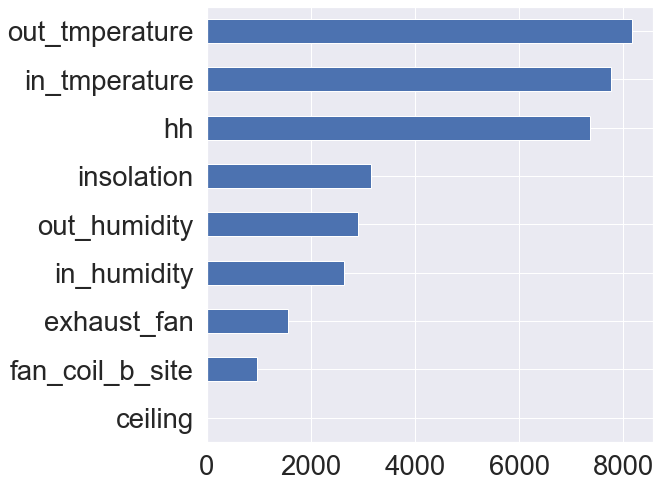

In [118]:
from pandas import Series

plt.figure(figsize=(8,8))
feature_importance = farm_lightgbm_model1.feature_importances_
model_feats = Series(feature_importance, index = farm_X_train1.columns)
model_feats.sort_values(ascending= True).plot.barh()
plt.show()

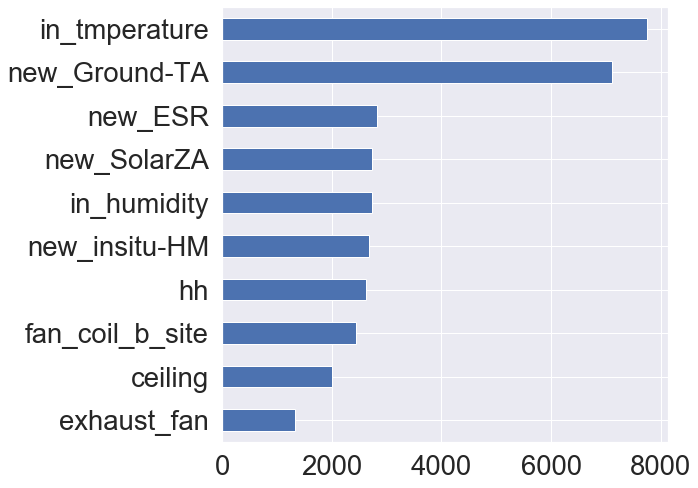

In [119]:
from pandas import Series

plt.figure(figsize=(8,8))
feature_importance = farm_lightgbm_model2.feature_importances_
model_feats = Series(feature_importance, index = farm_X_train2.columns)
model_feats.sort_values(ascending= True).plot.barh()
plt.show()